Convergence rate (dx/dy): 2.02
0.1
0.05
0.025
Convergence rate (dt): 2.09


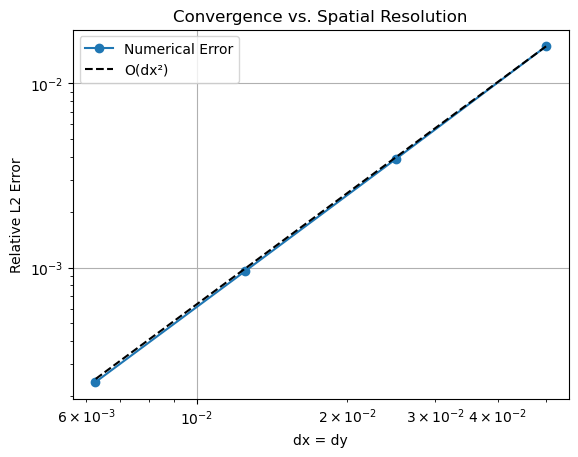

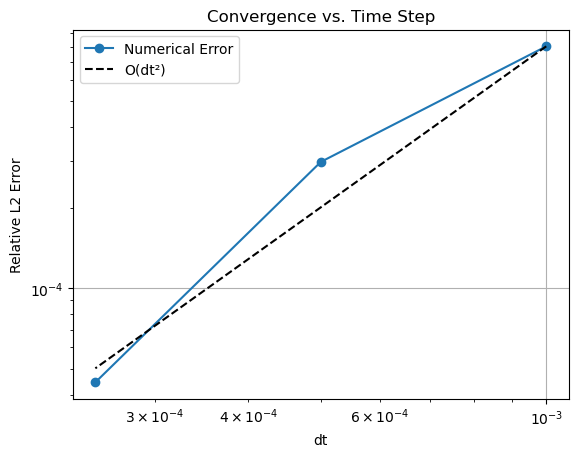

In [3]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

def analytical_solution(x, y, t, c):
    return np.sin(np.pi * x[:, None]) * np.sin(np.pi * y[None, :]) * np.cos(np.sqrt(2) * np.pi * c * t)

def build_laplacian(Nx, Ny, dx2, dy2):
    Ix = sp.eye(Nx)
    Iy = sp.eye(Ny)

    Dx = sp.diags([1, -2, 1], [-1, 0, 1], shape=(Nx, Nx)) / dx2
    Dy = sp.diags([1, -2, 1], [-1, 0, 1], shape=(Ny, Ny)) / dy2

    L = sp.kron(Iy, Dx) + sp.kron(Dy, Ix)
    return L.tocsr()

def apply_dirichlet_bc(u_vec, Nx, Ny):
    u = u_vec.reshape(Nx, Ny)
    u[0, :] = u[-1, :] = u[:, 0] = u[:, -1] = 0
    return u.reshape(-1)

def run_wave_solver(Nx, Ny, dt, T_fin, c):
    Lx = Ly = 1.0
    dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
    Nt = int(T_fin / dt)
    
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    u = np.sin(np.pi * X) * np.sin(np.pi * Y)

    dx2, dy2 = dx**2, dy**2
    L = build_laplacian(Nx, Ny, dx2, dy2)

    flatten = lambda arr: arr.reshape(-1)
    u_vec = flatten(u)

    # --- Second-order accurate initialization for u_old_vec ---
    u_lap = L @ u_vec
    u_old_vec = u_vec - 0.5 * dt**2 * c**2 * u_lap

    # Apply Dirichlet BCs to initial steps
    u_vec = apply_dirichlet_bc(u_vec, Nx, Ny)
    u_old_vec = apply_dirichlet_bc(u_old_vec, Nx, Ny)

    N = Nx * Ny
    I = sp.eye(N)
    A = 2 * I + (c**2 * dt**2) * L
    B = -1 * I

    for n in range(Nt):
        u_new_vec = A @ u_vec + B @ u_old_vec

        u_old_vec = apply_dirichlet_bc(u_vec, Nx, Ny)
        u_vec = apply_dirichlet_bc(u_new_vec, Nx, Ny)

    u_num = u_vec.reshape(Nx, Ny)
    u_exact = analytical_solution(x, y, T_fin, c)
    error = np.linalg.norm(u_num - u_exact) / np.linalg.norm(u_exact)
    return error, dx, dy, dt


# -------- Convergence with dx/dy --------
def convergence_dxdy():
    Ns = [21, 41, 81, 161]
    errors = []
    hs = []

    c = 1.0
    T_fin = 1
    CFL = 0.4

    for N in Ns:
        dx = 1.0 / (N - 1)
        dt = CFL * dx / c
        error, _, _, _ = run_wave_solver(N, N, dt, T_fin, c)
        errors.append(error)
        hs.append(dx)

    slope, _ = np.polyfit(np.log(hs), np.log(errors), 1)
    print(f"Convergence rate (dx/dy): {slope:.2f}")

    plt.figure()
    plt.loglog(hs, errors, 'o-', label='Numerical Error')
    plt.loglog(hs, [errors[0]*(h/hs[0])**2 for h in hs], 'k--', label='O(dx²)')
    plt.xlabel('dx = dy')
    plt.ylabel('Relative L2 Error')
    plt.title('Convergence vs. Spatial Resolution')
    plt.legend()
    plt.grid(True)

# -------- Convergence with dt --------
def convergence_dt():
    dt_values = [0.001, 0.0005, 0.00025]
    errors = []

    Nx = Ny = 101
    dx = 1.0 / (Nx - 1)
    c = 1.0
    T_fin = 5

    for dt in dt_values:
        print(dt/dx*c)
        error, _, _, _ = run_wave_solver(Nx, Ny, dt, T_fin, c)
        errors.append(error)

    slope, _ = np.polyfit(np.log(dt_values), np.log(errors), 1)
    print(f"Convergence rate (dt): {slope:.2f}")

    plt.figure()
    plt.loglog(dt_values, errors, 'o-', label='Numerical Error')
    plt.loglog(dt_values, [errors[0]*(dt/dt_values[0])**2 for dt in dt_values], 'k--', label='O(dt²)')
    plt.xlabel('dt')
    plt.ylabel('Relative L2 Error')
    plt.title('Convergence vs. Time Step')
    plt.legend()
    plt.grid(True)

# -------- Run All --------
convergence_dxdy()
convergence_dt()
plt.show()